In [1]:
import mhcflurry, seaborn, numpy, pandas, pickle, sklearn, collections, scipy, time
import mhcflurry.dataset
import fancyimpute, locale
from matplotlib import pyplot


import sklearn.metrics
import sklearn.cross_validation
%matplotlib inline


def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')

Using Theano backend.
/Users/tim/venvs/analysis-venv-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Couldn't import dot_parser, loading of dot files will not be possible.


/Users/tim/venvs/analysis-venv-2.7/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
max_ic50 = 50000
data_dir = "../data/"

In [3]:
all_train_data = mhcflurry.dataset.Dataset.from_csv(data_dir + "bdata.2009.mhci.public.1.txt")

In [4]:
def make_scores(ic50_y, ic50_y_pred, sample_weight=None, threshold_nm=500):     
    y_pred = mhcflurry.regression_target.ic50_to_regression_target(ic50_y_pred, max_ic50)
    try:
        auc = sklearn.metrics.roc_auc_score(ic50_y <= threshold_nm, y_pred, sample_weight=sample_weight)
    except ValueError:
        auc = numpy.nan
    try:
        f1 = sklearn.metrics.f1_score(ic50_y <= threshold_nm, ic50_y_pred <= threshold_nm, sample_weight=sample_weight)
    except ValueError:
        f1 = numpy.nan
    try:
        tau = scipy.stats.kendalltau(ic50_y_pred, ic50_y)[0]
    except ValueError:
        tau = numpy.nan
    
    return dict(
        auc=auc,
        f1=f1,
        tau=tau,
    )  

In [5]:
models = pandas.read_csv("../data/validation_models.csv", converters={'layer_sizes': eval})
models["layer_size"] = [x[0] for x in models.layer_sizes]
del models["activation"]
models

,dropout_probability,embedding_output_dim,fraction_negative,impute,layer_sizes,layer_size
0,0.5,32,0.0,False,[64],64
1,0.5,32,0.0,True,[64],64
2,0.5,32,0.2,False,[64],64
3,0.5,32,0.2,True,[64],64


In [6]:
def name_model(row):
    size = "big" if row.embedding_output_dim == 32 else "small"
    pieces = [size]
    if row.dropout_probability > 0:
        pieces.append("dropout")
    if row.impute:
        pieces.append("impute")
    return " ".join(pieces)

models["num"] = models.index
models["name"] = [name_model(row) for (_, row) in models.iterrows()]
models

,dropout_probability,embedding_output_dim,fraction_negative,impute,layer_sizes,layer_size,num,name
0,0.5,32,0.0,False,[64],64,0,big dropout
1,0.5,32,0.0,True,[64],64,1,big dropout impute
2,0.5,32,0.2,False,[64],64,2,big dropout
3,0.5,32,0.2,True,[64],64,3,big dropout impute


In [7]:
model_groups = models.groupby("name").num.unique()
model_groups

name
big dropout           [0, 2]
big dropout impute    [1, 3]
Name: num, dtype: object

In [8]:
validation_df_with_mhcflurry_results = pandas.read_csv("../data/validation_predictions_full.csv")
validation_df_with_mhcflurry_results

,allele,peptide,length,meas,netmhc,netmhcpan,smmpmbec_cpp,mhcflurry 0,mhcflurry 1,mhcflurry 2,mhcflurry 3
0,H-2-DB,AAACNVATA,9,657.657837,154.881662,711.213514,438.530698,1442.126816,1230.322823,1277.631488,364.773670
1,H-2-DB,AAFEFVYV,8,30831.879502,6456.542290,785.235635,10351.421667,11473.595261,12327.145996,12685.090199,8186.470538
2,H-2-DB,AAFVNDYSL,9,77.446180,17.458222,7.516229,28.054336,18.691766,31.570829,21.826293,17.622147
3,H-2-DB,AAIANQAAV,9,1.999862,9.638290,9.749896,25.703958,4.279559,4.320936,5.741265,4.149827
4,H-2-DB,AAIANQAVV,9,1.517050,8.550667,8.336812,28.773984,3.503900,3.545383,4.403022,3.479555
5,H-2-DB,AAIENYVRF,9,37.844258,252.348077,114.815362,187.068214,325.846385,203.968140,378.604284,133.562226
6,H-2-DB,AAINFITTM,9,3.155005,199.986187,389.045145,200.909281,38.287690,80.587676,100.644543,31.089573
7,H-2-DB,AAIPAPPPI,9,3243.396173,1059.253725,493.173804,295.120923,450.264145,471.683475,817.682084,560.212784
8,H-2-DB,AAKLNRPPL,9,654.636174,66.374307,77.268059,38.459178,103.544944,116.724333,247.518551,108.927801
9,H-2-DB,AALDMVDAL,9,229.614865,547.015963,597.035287,225.423921,1401.468773,1236.987110,3250.940299,1010.833977


In [9]:
# Extend with ensemble predictions
all_indices = sorted(set.union(*[set(indices) for (name, indices) in model_groups.iteritems()]))
all_indices_impute = sorted(
    set.union(*[set(indices) for (name, indices) in model_groups.iteritems() if 'impute' in name]))
all_indices_not_impute = sorted(
    set.union(*[set(indices) for (name, indices) in model_groups.iteritems() if 'impute' not in name]))

for (name, indices) in list(model_groups.iteritems()) + [("all", all_indices), ("all impute", all_indices_impute), ("all not impute", all_indices_not_impute)]:
    validation_df_with_mhcflurry_results["mhcflurry ensemble %s" % name] = \
        scipy.stats.mstats.gmean(
            validation_df_with_mhcflurry_results[["mhcflurry %d" % i for i in indices]],
            axis=1)

validation_df_with_mhcflurry_results

,allele,peptide,length,meas,netmhc,netmhcpan,smmpmbec_cpp,mhcflurry 0,mhcflurry 1,mhcflurry 2,mhcflurry 3,mhcflurry ensemble big dropout,mhcflurry ensemble big dropout impute,mhcflurry ensemble all,mhcflurry ensemble all impute,mhcflurry ensemble all not impute
0,H-2-DB,AAACNVATA,9,657.657837,154.881662,711.213514,438.530698,1442.126816,1230.322823,1277.631488,364.773670,1357.389638,669.917436,953.592673,669.917436,1357.389638
1,H-2-DB,AAFEFVYV,8,30831.879502,6456.542290,785.235635,10351.421667,11473.595261,12327.145996,12685.090199,8186.470538,12064.144843,10045.686513,11008.751843,10045.686513,12064.144843
2,H-2-DB,AAFVNDYSL,9,77.446180,17.458222,7.516229,28.054336,18.691766,31.570829,21.826293,17.622147,20.198316,23.586984,21.826987,23.586984,20.198316
3,H-2-DB,AAIANQAAV,9,1.999862,9.638290,9.749896,25.703958,4.279559,4.320936,5.741265,4.149827,4.956822,4.234517,4.581457,4.234517,4.956822
4,H-2-DB,AAIANQAVV,9,1.517050,8.550667,8.336812,28.773984,3.503900,3.545383,4.403022,3.479555,3.927817,3.512315,3.714261,3.512315,3.927817
5,H-2-DB,AAIENYVRF,9,37.844258,252.348077,114.815362,187.068214,325.846385,203.968140,378.604284,133.562226,351.236156,165.052836,240.774840,165.052836,351.236156
6,H-2-DB,AAINFITTM,9,3.155005,199.986187,389.045145,200.909281,38.287690,80.587676,100.644543,31.089573,62.076139,50.054335,55.742083,50.054335,62.076139
7,H-2-DB,AAIPAPPPI,9,3243.396173,1059.253725,493.173804,295.120923,450.264145,471.683475,817.682084,560.212784,606.772547,514.045827,558.488045,514.045827,606.772547
8,H-2-DB,AAKLNRPPL,9,654.636174,66.374307,77.268059,38.459178,103.544944,116.724333,247.518551,108.927801,160.091519,112.758702,134.356659,112.758702,160.091519
9,H-2-DB,AALDMVDAL,9,229.614865,547.015963,597.035287,225.423921,1401.468773,1236.987110,3250.940299,1010.833977,2134.500249,1118.207763,1544.931956,1118.207763,2134.500249


In [10]:
scores_df = collections.defaultdict(list)
predictors = validation_df_with_mhcflurry_results.columns[4:]
pairs = [
    ("overall", validation_df_with_mhcflurry_results)
] + list(validation_df_with_mhcflurry_results.groupby("allele"))

for (allele, grouped) in pairs:
    scores_df["allele"].append(allele)
    scores_df["test_size"].append(len(grouped.meas))
    for predictor in predictors:
        scores = make_scores(grouped.meas, grouped[predictor])
        for (key, value) in scores.items():
            scores_df["%s_%s" % (predictor, key)].append(value)
            
scores_df = pandas.DataFrame(scores_df)
scores_df["train_size"] = [
        len(all_train_data.groupby_allele_dictionary()[a]) if a != 'overall' else numpy.nan
        for a in scores_df.allele
    ]
scores_df.index = scores_df.allele
scores_df

/Users/tim/venvs/analysis-venv-2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tim/venvs/analysis-venv-2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


,allele,mhcflurry 0_auc,mhcflurry 0_f1,mhcflurry 0_tau,mhcflurry 1_auc,mhcflurry 1_f1,mhcflurry 1_tau,mhcflurry 2_auc,mhcflurry 2_f1,mhcflurry 2_tau,...,netmhc_f1,netmhc_tau,netmhcpan_auc,netmhcpan_f1,netmhcpan_tau,smmpmbec_cpp_auc,smmpmbec_cpp_f1,smmpmbec_cpp_tau,test_size,train_size
allele,,,,,,,,,,,,,,,,,,,,,
overall,overall,0.927733,0.780452,0.575551,0.926805,0.781977,0.576826,0.929323,0.770265,0.577676,...,0.800909,0.582258,0.932924,0.793170,0.579586,0.919208,0.784295,0.561996,27680,NaN
H-2-DB,H-2-DB,0.912222,0.593886,0.634828,0.915309,0.612766,0.640775,0.905614,0.580357,0.625557,...,0.621212,0.600337,0.874574,0.577236,0.574262,0.884187,0.628571,0.571252,564,3216
H-2-KB,H-2-KB,0.907870,0.812165,0.589815,0.908143,0.819149,0.591965,0.909597,0.802893,0.593356,...,0.813675,0.573199,0.825565,0.665354,0.486836,0.915994,0.859967,0.589218,558,3407
H-2-KD,H-2-KD,0.773768,0.584615,0.357916,0.776589,0.604651,0.355835,0.793761,0.589147,0.385118,...,0.657718,0.403275,0.819189,0.645570,0.390333,0.753692,0.538462,0.365247,229,452
HLA-A0101,HLA-A0101,0.912949,0.605714,0.519646,0.903609,0.631016,0.514472,0.909852,0.613636,0.516242,...,0.619565,0.524866,0.894895,0.594286,0.498767,0.832665,0.437811,0.428064,696,3725
HLA-A0201,HLA-A0201,0.929486,0.878578,0.623194,0.930293,0.879897,0.625150,0.930269,0.875983,0.625099,...,0.884336,0.635498,0.930479,0.880963,0.637338,0.927358,0.885121,0.626224,2126,9565
HLA-A0202,HLA-A0202,0.895233,0.755556,0.611888,0.900499,0.755556,0.615726,0.905765,0.761905,0.605748,...,0.755556,0.627143,0.898697,0.769231,0.624280,0.882206,0.727273,0.606938,126,3919
HLA-A0203,HLA-A0203,0.977392,0.954976,0.578919,0.978112,0.952494,0.592381,0.976223,0.953293,0.589924,...,0.948626,0.586911,0.974158,0.944578,0.591463,0.972885,0.946746,0.583908,651,5542
HLA-A0206,HLA-A0206,0.907647,0.870210,0.540573,0.903137,0.870098,0.532982,0.906622,0.867168,0.537858,...,0.872902,0.543184,0.910796,0.866258,0.535067,0.904317,0.878282,0.527571,682,4827


In [11]:
scores_df.ix["HLA-A3101"]

allele                                       HLA-A3101
mhcflurry 0_auc                              0.8479397
mhcflurry 0_f1                               0.8166877
mhcflurry 0_tau                              0.4949753
mhcflurry 1_auc                              0.8472576
mhcflurry 1_f1                               0.8229426
mhcflurry 1_tau                              0.4964571
mhcflurry 2_auc                              0.8497869
mhcflurry 2_f1                               0.7984395
mhcflurry 2_tau                              0.4938253
mhcflurry 3_auc                              0.8507833
mhcflurry 3_f1                               0.8092784
mhcflurry 3_tau                              0.4997911
mhcflurry ensemble all impute_auc            0.8503771
mhcflurry ensemble all impute_f1             0.8226415
mhcflurry ensemble all impute_tau            0.5018517
mhcflurry ensemble all not impute_auc        0.8498099
mhcflurry ensemble all not impute_f1         0.8117048
mhcflurry 

In [12]:
print(" ".join(scores_df.index))
print(scores_df.shape)

overall H-2-DB H-2-KB H-2-KD HLA-A0101 HLA-A0201 HLA-A0202 HLA-A0203 HLA-A0206 HLA-A0301 HLA-A1101 HLA-A2301 HLA-A2402 HLA-A2501 HLA-A2601 HLA-A2602 HLA-A2603 HLA-A2902 HLA-A3001 HLA-A3002 HLA-A3101 HLA-A3201 HLA-A3301 HLA-A6801 HLA-A6802 HLA-A6901 HLA-A8001 HLA-B0702 HLA-B0801 HLA-B0802 HLA-B0803 HLA-B1501 HLA-B1503 HLA-B1509 HLA-B1517 HLA-B1801 HLA-B2703 HLA-B2705 HLA-B3501 HLA-B3801 HLA-B3901 HLA-B4001 HLA-B4002 HLA-B4402 HLA-B4403 HLA-B4501 HLA-B4601 HLA-B5101 HLA-B5301 HLA-B5401 HLA-B5701 HLA-B5801 Mamu-A01 Mamu-A02
(54, 39)


In [66]:
print_full(scores_df.ix["overall"].sort(inplace=False, ascending=False))

allele                                         overall
test_size                                        27680
netmhcpan_auc                                0.9329235
mhcflurry ensemble all_auc                   0.9307122
mhcflurry ensemble big dropout_auc           0.9306644
mhcflurry ensemble all not impute_auc        0.9306644
netmhc_auc                                   0.9299468
mhcflurry ensemble big dropout impute_auc    0.9299198
mhcflurry ensemble all impute_auc            0.9299198
mhcflurry 2_auc                              0.9293233
mhcflurry 3_auc                              0.9287587
mhcflurry 0_auc                              0.9277326
mhcflurry 1_auc                              0.9268053
smmpmbec_cpp_auc                             0.9192085
netmhc_f1                                     0.800909
netmhcpan_f1                                   0.79317
smmpmbec_cpp_f1                              0.7842948
mhcflurry 1_f1                               0.7819771
mhcflurry 

In [79]:
scores_df.ix[(scores_df.index != "overall") & (scores_df.train_size >= 500)].shape

(44, 39)

In [80]:
print_full(scores_df.ix[(scores_df.index != "overall") & (scores_df.train_size >= 500)].mean(0).sort(inplace=False, ascending=False))

train_size                                   2656.227273
test_size                                     558.181818
mhcflurry ensemble all_auc                      0.911521
mhcflurry ensemble big dropout_auc              0.911310
mhcflurry ensemble all not impute_auc           0.911310
mhcflurry ensemble big dropout impute_auc       0.910493
mhcflurry ensemble all impute_auc               0.910493
mhcflurry 3_auc                                 0.910256
netmhcpan_auc                                   0.909513
mhcflurry 2_auc                                 0.909055
netmhc_auc                                      0.908575
mhcflurry 0_auc                                 0.908213
mhcflurry 1_auc                                 0.906355
smmpmbec_cpp_auc                                0.893122
netmhcpan_f1                                    0.720172
netmhc_f1                                       0.717352
smmpmbec_cpp_f1                                 0.696423
mhcflurry 0_f1                 

In [46]:
scores_df.train_size

allele
overall       NaN
H-2-DB       3216
H-2-KB       3407
H-2-KD        452
HLA-A0101    3725
HLA-A0201    9565
HLA-A0202    3919
HLA-A0203    5542
HLA-A0206    4827
HLA-A0301    6141
HLA-A1101    5399
HLA-A2301    2021
HLA-A2402    2533
HLA-A2501     519
HLA-A2601    2894
HLA-A2602     202
HLA-A2603     205
HLA-A2902    2397
HLA-A3001    2040
HLA-A3002    1430
HLA-A3101    4796
HLA-A3201     640
HLA-A3301    3040
HLA-A6801    3184
HLA-A6802    4768
HLA-A6901    2079
HLA-A8001     782
HLA-B0702    3412
HLA-B0801    2267
HLA-B0802     487
HLA-B0803     217
HLA-B1501    3213
HLA-B1503     429
HLA-B1509     346
HLA-B1517     846
HLA-B1801    2052
HLA-B2703     433
HLA-B2705    3028
HLA-B3501    2397
HLA-B3801     136
HLA-B3901     886
HLA-B4001    2718
HLA-B4002     866
HLA-B4402    1705
HLA-B4403     913
HLA-B4501     889
HLA-B4601    1424
HLA-B5101    1734
HLA-B5301    1018
HLA-B5401    1019
HLA-B5701    1857
HLA-B5801    2564
Mamu-A01     2264
Mamu-A02      938
Name: train_size, dty

In [49]:
models

,dropout_probability,embedding_output_dim,fraction_negative,impute,layer_sizes,layer_size,num,name
0,0.5,32,0.0,False,[64],64,0,big dropout
1,0.5,32,0.0,True,[64],64,1,big dropout impute
2,0.5,32,0.2,False,[64],64,2,big dropout
3,0.5,32,0.2,True,[64],64,3,big dropout impute


In [63]:
validation_df_with_mhcflurry_results["binder"] = validation_df_with_mhcflurry_results.meas < 500
grouped = validation_df_with_mhcflurry_results.groupby("allele")
(grouped.meas.std() > 0) & (grouped.binder.std() > 0)

allele
H-2-DB        True
H-2-KB        True
H-2-KD        True
HLA-A0101     True
HLA-A0201     True
HLA-A0202     True
HLA-A0203     True
HLA-A0206     True
HLA-A0301     True
HLA-A1101     True
HLA-A2301     True
HLA-A2402     True
HLA-A2501     True
HLA-A2601     True
HLA-A2602     True
HLA-A2603     True
HLA-A2902     True
HLA-A3001     True
HLA-A3002     True
HLA-A3101     True
HLA-A3201     True
HLA-A3301     True
HLA-A6801     True
HLA-A6802     True
HLA-A6901     True
HLA-A8001     True
HLA-B0702     True
HLA-B0801     True
HLA-B0802     True
HLA-B0803     True
HLA-B1501     True
HLA-B1503     True
HLA-B1509     True
HLA-B1517     True
HLA-B1801     True
HLA-B2703    False
HLA-B2705     True
HLA-B3501     True
HLA-B3801     True
HLA-B3901     True
HLA-B4001     True
HLA-B4002     True
HLA-B4402     True
HLA-B4403     True
HLA-B4501     True
HLA-B4601    False
HLA-B5101     True
HLA-B5301     True
HLA-B5401     True
HLA-B5701     True
HLA-B5801     True
Mamu-A01      True
Mamu-

In [76]:
(validation_df_with_mhcflurry_results.ix[validation_df_with_mhcflurry_results.allele == "HLA-B3801"].meas < 500).mean()

0.40170940170940173

In [68]:
scores_df.ix[
    scores_df.train_size < 500
][["train_size", "mhcflurry 2_auc", "mhcflurry 3_auc", "netmhc_auc", "netmhcpan_auc"]].sort("train_size", inplace=False)

,train_size,mhcflurry 2_auc,mhcflurry 3_auc,netmhc_auc,netmhcpan_auc
allele,,,,,
HLA-B3801,136,0.909895,0.854171,0.925684,0.980074
HLA-A2602,202,0.926848,0.921058,0.931577,0.957811
HLA-A2603,205,0.900344,0.883735,0.890172,0.934300
HLA-B0803,217,0.935802,0.941728,0.968395,0.952346
HLA-B1509,346,0.882585,0.849996,0.901247,0.922907
HLA-B1503,429,0.840909,0.857438,0.864784,0.870064
HLA-B2703,433,NaN,NaN,NaN,NaN
H-2-KD,452,0.793761,0.792185,0.815331,0.819189
HLA-B0802,487,0.984499,0.984386,0.989930,0.989590


In [64]:
print_full(scores_df.ix[(scores_df.index != "overall") & (scores_df.train_size < 1000)].mean(0).sort(inplace=False, ascending=False))

train_size                                   565.888889
test_size                                    360.666667
netmhcpan_auc                                  0.936087
netmhc_auc                                     0.926065
mhcflurry ensemble all not impute_auc          0.917750
mhcflurry ensemble big dropout_auc             0.917750
mhcflurry ensemble all_auc                     0.917658
mhcflurry 2_auc                                0.915545
mhcflurry ensemble big dropout impute_auc      0.915021
mhcflurry ensemble all impute_auc              0.915021
mhcflurry 0_auc                                0.911218
mhcflurry 3_auc                                0.910943
mhcflurry 1_auc                                0.908827
smmpmbec_cpp_auc                               0.905258
netmhcpan_f1                                   0.565589
netmhc_f1                                      0.527323
mhcflurry ensemble big dropout impute_f1       0.510129
mhcflurry ensemble all impute_f1               0

In [67]:
print_full(scores_df.ix[scores_df.index != "overall"].mean(0).sort(inplace=False, ascending=False))

train_size                                   2260.018868
test_size                                     522.264151
netmhcpan_auc                                   0.912458
mhcflurry ensemble all_auc                      0.909909
mhcflurry ensemble big dropout_auc              0.909660
mhcflurry ensemble all not impute_auc           0.909660
netmhc_auc                                      0.908938
mhcflurry ensemble all impute_auc               0.908434
mhcflurry ensemble big dropout impute_auc       0.908434
mhcflurry 2_auc                                 0.907137
mhcflurry 3_auc                                 0.906386
mhcflurry 0_auc                                 0.906017
mhcflurry 1_auc                                 0.904506
smmpmbec_cpp_auc                                0.893880
netmhcpan_f1                                    0.662084
netmhc_f1                                       0.650962
mhcflurry ensemble big dropout impute_f1        0.634057
mhcflurry ensemble all impute_f

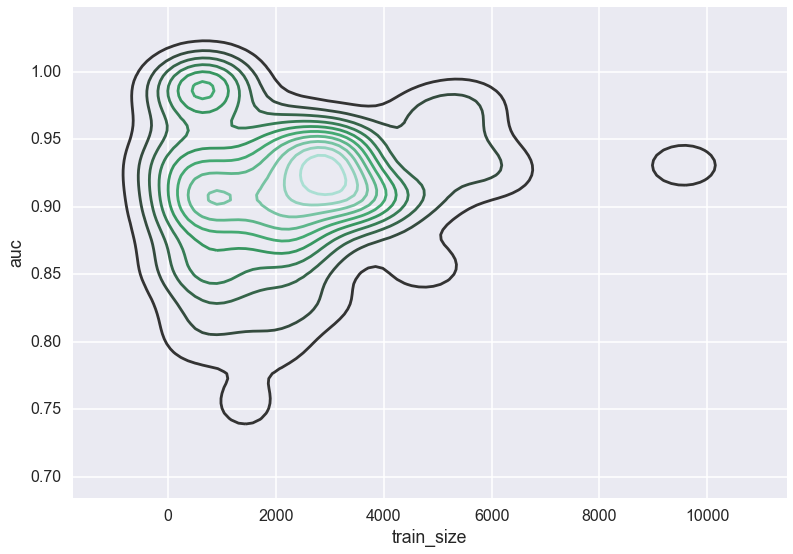

In [45]:
#pyplot.figure(figsize=(20,5))
data=scores_df[[
        "mhcflurry 2_auc",
        "mhcflurry 3_auc",
        "netmhc_auc",
        "netmhcpan_auc"
]].stack().to_frame().reset_index()
data.columns = ["allele", "predictor", "auc"]
data["train_size"] = [scores_df.ix[scores_df.allele == a].train_size.unique()[0] for a in data.allele]
data = data[data.allele != "overall"]
#data.columns
#data
seaborn.set_context('poster')
seaborn.kdeplot(data.train_size, data.auc, hue=data.predictor)


In [18]:
scores_df.plot?

In [20]:
scores_df[["mhcflurry 6_auc", "netmhc_auc", "netmhcpan_auc"]].plot

KeyError: "['mhcflurry 6_auc'] not in index"

In [ ]:
scores_df.ix[:, "mhcflurry ensemble small impute_auc"] / scores_df.ix[:, "netmhc_auc"]

In [ ]:
def sub_df(name):
    result = scores_df[[c for c in list(scores_df.columns) if (name + "_") in c]].copy()
    result.columns = [c.split("_")[-1] for c in list(result.columns)]
    return result

d = dict((name, sub_df(name)) for name in predictors)
panel = pandas.Panel(d)
 
panel